In [1]:
#| default_exp experiment

In [2]:
# | export

import os
import time
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, BatchNormalization,
    GlobalAveragePooling2D, Dense, Dropout, Activation
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

2025-07-27 09:16:02.325111: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 09:16:02.325815: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 09:16:02.329195: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-07-27 09:16:02.338139: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753587962.353748  456329 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753587962.35

In [3]:
# | export

from openfl.experimental.workflow.interface import FLSpec, Aggregator, Collaborator
from openfl.experimental.workflow.placement import aggregator, collaborator
from openfl.experimental.workflow.runtime import LocalRuntime
from openfl.experimental.workflow.runtime import FederatedRuntime
from metaflow import Metaflow, Flow, Step, Task
from tabulate import tabulate

/home/intel/anjali/temp/project_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-27 09:16:04,140	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [4]:
# | export

def brats_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding="same", input_shape=input_shape),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Conv2D(64, (3,3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D((2, 2)),

        Conv2D(256, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        GlobalAveragePooling2D(),

        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [5]:
# | export

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [6]:
# | export

def FedAvg(agg_model, models):
    weights = [model.get_weights() for model in models]
    avg_weights = [np.mean(w, axis=0) for w in zip(*weights)]
    agg_model.set_weights(avg_weights)
    return agg_model

In [7]:
# | export

def visualize_metadata(collaborator_metadata):
    print("[Aggregator] Visualizing metadata:")

    collaborators = list(collaborator_metadata.keys())
    all_meta = list(collaborator_metadata.values())
    
    # Class distribution
    plt.figure(figsize=(8, 5))
    for i, (collab, meta) in enumerate(collaborator_metadata.items()):
        class_dist = meta.get("class_distribution", {})
        classes = list(class_dist.keys())
        values = list(class_dist.values())
        plt.bar([f"{cls}_{collab}" for cls in classes], values, alpha=0.6, label=collab)
    plt.title("Class Distribution per Collaborator")
    plt.ylabel("Sample Count")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Mean intensity per modality
    modalities = set()
    for meta in all_meta:
        stats = meta.get("stats", {})
        modalities.update(stats.keys())
    modalities = sorted(modalities)
    plt.figure(figsize=(10, 5))
    for modality in modalities:
        means = []
        for meta in all_meta:
            stats = meta.get("stats", {})
            mean = stats.get(modality, {}).get("mean", None)
            means.append(mean)
        plt.plot(range(len(all_meta)), means, marker='o', label=modality)
    plt.xticks(range(len(all_meta)), collaborators)
    plt.title("Mean Intensity per Modality")
    plt.ylabel("Mean Intensity")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [8]:
# | export

# Federated Learning Workflow
class FederatedBrats(FLSpec):
    def __init__(self, model=None, rounds=3, **kwargs):
        super().__init__(**kwargs)
        if model is not None:
            self.model = model
            # self.optimizer = optimizer
        else:
            self.model = brats_model((128, 128, 4))
        self.callbacks = [
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
        ]
        self.rounds = rounds
        self.results = []
        self.collaborator_metadata = {}

    @aggregator
    def start(self):
        print("Initializing Federated Learning Workflow")
        self.collaborators = self.runtime.collaborators
        self.current_round = 0
        self.private = 10
        self.next(self.aggregated_model_validation, foreach="collaborators", exclude=["private"])      

    @collaborator
    def aggregated_model_validation(self):
        print(f"Validating aggregated model for collaborator {self.input}")
        val_loss, val_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=0)
        self.agg_validation_score = val_acc
        print(f'{self.input} value of {self.agg_validation_score}')
        self.next(self.train)

    @collaborator
    def train(self):
        self.labels = self.metadata
        print(f"Training model on local dataset for collaborator {self.input}")
        augmented_data = datagen.flow(self.train_data, self.train_labels, batch_size=BATCH_SIZE)

        orig_train_labels = np.argmax(self.train_labels, axis=1)
        orig_test_labels = np.argmax(self.test_labels, axis=1)
        all_labels = np.concatenate([orig_train_labels, orig_test_labels], axis=0)
        
        class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=all_labels)
        class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

        self.history = self.model.fit(
            augmented_data,
            epochs=100,
            batch_size=BATCH_SIZE,
            verbose=1,
            callbacks=self.callbacks,
            validation_data=(self.test_data, self.test_labels),
            class_weight=class_weight_dict)
        
        self.loss = self.history.history['loss'][-1]
        self.training_completed = True
        self.next(self.local_model_validation)

    @collaborator
    def local_model_validation(self):
        val_loss, val_acc = self.model.evaluate(self.test_data, self.test_labels, verbose=0)
        self.local_validation_score = val_acc
        print(f'Doing local model validation for collaborator {self.input}: {self.local_validation_score}')
        self.next(self.join, exclude=["training_completed"])

    @aggregator
    def join(self, inputs):
        print(f"[Aggregator] Joining round {self.current_round}")

        tolerance_ratio = 0.1
        tolerance_mean = 0.05
        self.collaborator_metadata = {input.input: input.labels for input in inputs}

        all_meta = list(self.collaborator_metadata.values())
        if len(all_meta) > 1:
            base_ratio = all_meta[0].get("class_ratio", {})
            for idx, meta in enumerate(all_meta[1:], start=1):
                comp_ratio = meta.get("class_ratio", {})
                for key in base_ratio:
                    diff = abs(base_ratio[key] - comp_ratio.get(key, 0))
                    if diff > tolerance_ratio:
                        print(f"Skipping round due to class ratio mismatch on class {key}: {base_ratio[key]} vs {comp_ratio.get(key, 0)}")
                        self.next(self.end)
                        return
                
            base_stats = all_meta[0].get("stats", {})
            for idx, meta in enumerate(all_meta[1:], start=1):
                comp_stats = meta.get("stats", {})
                for modality in base_stats:
                    for key in ["mean", "median"]:
                        diff = abs(base_stats[modality][key] - comp_stats[modality][key])
                        if diff > tolerance_mean:
                            print(f"Skipping round due to stats mismatch on {modality}: {base_stats[modality]} vs {comp_stats.get(modality, 0)}")
                            self.next(self.end)
                            return
        
        self.average_loss = sum(input.loss for input in inputs) / len(inputs)
        self.aggregated_model_accuracy = sum(input.agg_validation_score for input in inputs) / len(inputs)
        self.local_model_accuracy = sum(input.local_validation_score for input in inputs) / len(inputs)
        print(f"Average aggregrated model validation values = {self.aggregated_model_accuracy}")
        print(f"Average training loss = {self.average_loss}")
        print(f"Average local model validation values = {self.local_model_accuracy}")

        collaborator_models = [input.model for input in inputs]
        self.model = FedAvg(self.model, collaborator_models)
        
        self.results.append([
            self.current_round,
            self.aggregated_model_accuracy,
            self.average_loss,
            self.local_model_accuracy
        ])
        
        self.current_round += 1
        if self.current_round < self.rounds:
            self.next(self.aggregated_model_validation, foreach="collaborators")
        else:
            self.next(self.end)

    @aggregator
    def end(self):
        print("Federated Learning Workflow Completed")

Aggregator step "start" registered
Collaborator step "aggregated_model_validation" registered
Collaborator step "train" registered
Collaborator step "local_model_validation" registered
Aggregator step "join" registered
Aggregator step "end" registered


In [9]:
# | export

BATCH_SIZE=16

In [10]:
# | export

fed_aggregator = Aggregator()
fed_aggregator.private_attributes = {}

n_collaborators = 2
collaborator_names = ["Sparsh", "Apollo"]
collaborators = []

In [11]:
# | export

os.environ["USERNAME"] = "intel"

model = None
optimizer = None
fl_brats = FederatedBrats(model, rounds=10)

/home/intel/anjali/temp/project_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-07-27 09:16:04.810589: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [12]:
# | export

director_info = {
    "director_node_fqdn":"localhost",
    "director_port":50050,
    "cert_chain": '/home/intel/anjali/temp/brats/workspace/cert/root_ca.crt',
    "api_cert": '/home/intel/anjali/temp/brats/workspace/cert/experiment.crt',
    "api_private_key": '/home/intel/anjali/temp/brats/workspace/cert/experiment.key',
}

federated_runtime = FederatedRuntime(
    collaborators=collaborator_names,
    director=director_info,
    notebook_path="./brats_2020.ipynb",
    tls=True
)

In [13]:
# | export

federated_runtime.get_envoys()

Status of Envoys connected to Federation at: 2025-07-27 09:16:04

+--------+----------+---------------------+----------------------+-------------------+
| Name   | Online   | Last Updated        | Experiment Running   | Experiment Name   |
+========+==========+=====================+======================+===================+
| Apollo | Yes      | 2025-07-27 09:16:01 | No                   | None              |
+--------+----------+---------------------+----------------------+-------------------+
| Sparsh | Yes      | 2025-07-27 09:16:03 | No                   | None              |
+--------+----------+---------------------+----------------------+-------------------+


['Apollo', 'Sparsh']

In [14]:
# | export

start_time = time.time()
print(f"Starting Federated Learning at: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(start_time)))

Starting Federated Learning at:  2025-07-27 09:16:05


Removing existing workspace: /home/intel/anjali/temp/brats/workspace/generated_workspace
Copied template workspace to /home/intel/anjali/temp/brats/workspace/generated_workspace
Converting jupyter notebook to python script...
Retrieved experiment from default_exp
Successfully generated /home/intel/anjali/temp/brats/workspace/generated_workspace/requirements.txt
Aggregator step "start" registered
Collaborator step "aggregated_model_validation" registered
Collaborator step "train" registered
Collaborator step "local_model_validation" registered
Aggregator step "join" registered
Aggregator step "end" registered
Starting Federated Learning at:  2025-07-27 09:16:05
Federated Learning completed at:  2025-07-27 09:16:05
Total time taken: 0.00 seconds
[Aggregator] Visualizing metadata:


/home/intel/anjali/temp/project_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intel/anjali/temp/brats/workspace/generated_workspace/src/experiment.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


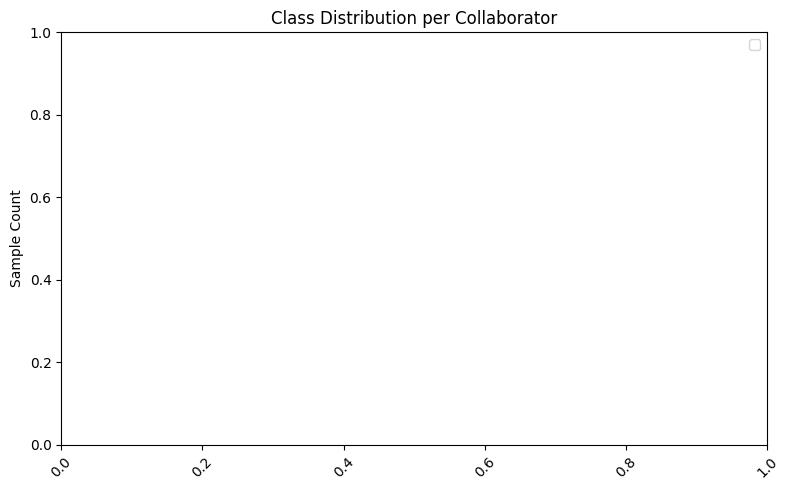

/home/intel/anjali/temp/brats/workspace/generated_workspace/src/experiment.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


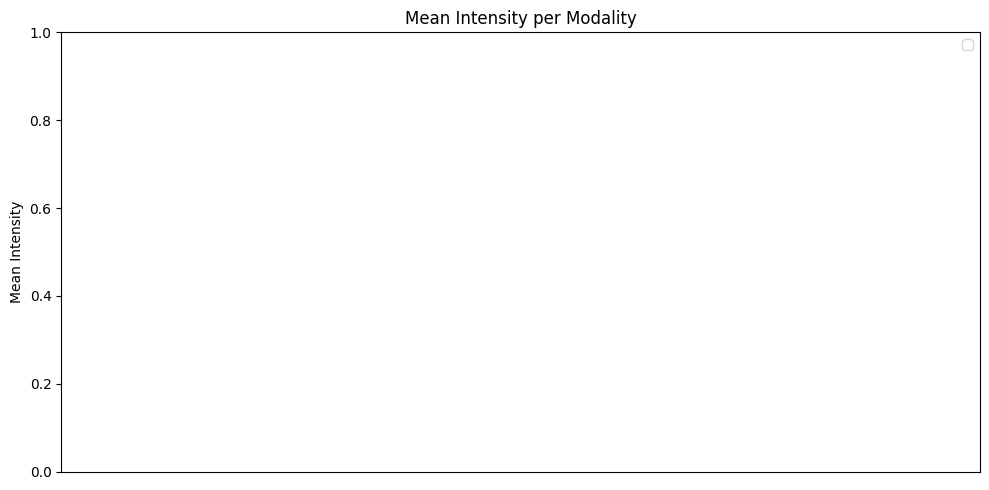

*************Federation Results****************
+----------+------------------------------+--------------------+--------------------------------+
| Rounds   | Agg Model Validation Score   | Local Train Loss   | Local Model Validation Score   |
+==========+==============================+====================+================================+
+----------+------------------------------+--------------------+--------------------------------+

New experimental workspace directory structure:
generated_workspace
├── requirements.txt
├── .workspace
├── src
│   ├── __init__.py
│   ├── __pycache__
│   └── experiment.py
└── plan
    └── plan.yaml

3 directories, 5 files
Archive created at /home/intel/anjali/temp/brats/workspace/experiment.zip
Experiment FederatedBrats was successfully submitted to the director!
Aggregator step "start" registered
Collaborator step "aggregated_model_validation" registered
Collaborator step "train" registered
Collaborator step "local_model_validation" registered
Aggre

/home/intel/anjali/temp/project_venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/intel/anjali/temp/brats/workspace/generated_workspace/src/experiment.py:97: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


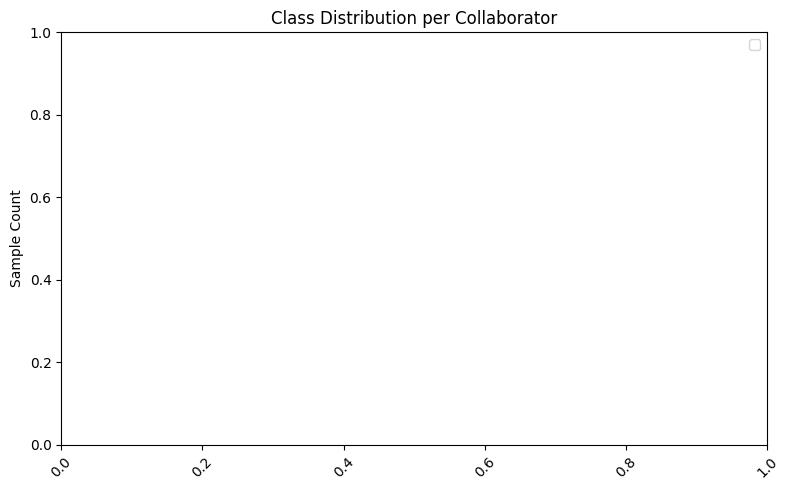

/home/intel/anjali/temp/brats/workspace/generated_workspace/src/experiment.py:118: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


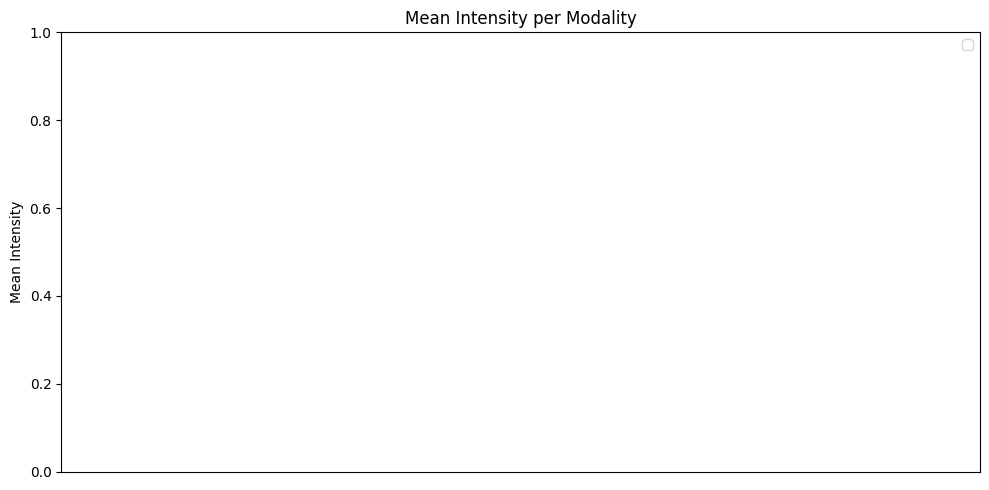

*************Federation Results****************
+----------+------------------------------+--------------------+--------------------------------+
| Rounds   | Agg Model Validation Score   | Local Train Loss   | Local Model Validation Score   |
+==========+==============================+====================+================================+
+----------+------------------------------+--------------------+--------------------------------+
Experiment ran successfully


In [15]:
# | export

fl_brats.results = []
fl_brats.runtime = federated_runtime
fl_brats.run()

In [16]:
# | export 

end_time = time.time()
print(f"Federated Learning completed at: ", time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(end_time)))
time_taken = end_time - start_time
print(f"Total time taken: {time_taken:.2f} seconds")

Federated Learning completed at:  2025-07-27 13:59:14
Total time taken: 16989.70 seconds


[Aggregator] Visualizing metadata:


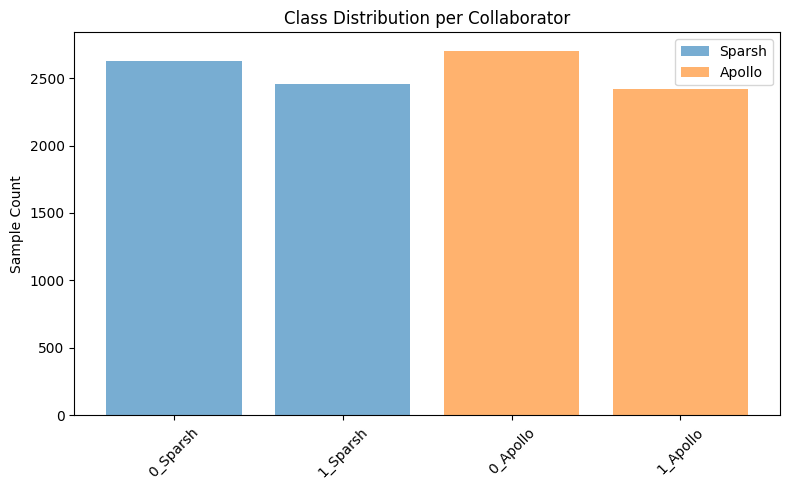

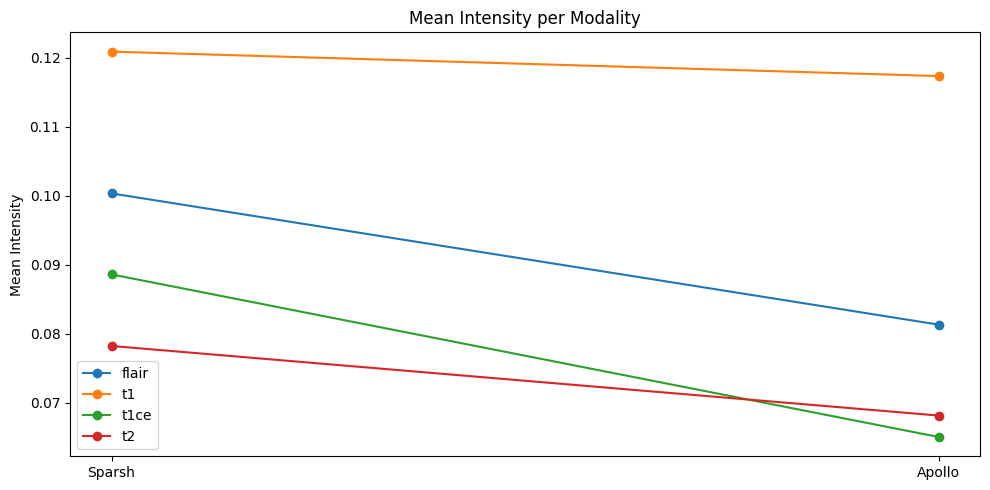

In [17]:
# | export

visualize_metadata(fl_brats.collaborator_metadata)

In [18]:
# | export

headers = ["Rounds", "Agg Model Validation Score", "Local Train Loss", "Local Model Validation Score"]
print("*************Federation Results****************")
federation_results = fl_brats.results
print(tabulate(federation_results, headers=headers, tablefmt="outline"))

*************Federation Results****************
+----------+------------------------------+--------------------+--------------------------------+
|   Rounds |   Agg Model Validation Score |   Local Train Loss |   Local Model Validation Score |
+==========+==============================+====================+================================+
|        0 |                     0.476338 |           0.310853 |                       0.883503 |
|        1 |                     0.476338 |           0.247935 |                       0.907029 |
|        2 |                     0.517434 |           0.20894  |                       0.927533 |
|        3 |                     0.921202 |           0.201813 |                       0.931476 |
|        4 |                     0.926113 |           0.184939 |                       0.939318 |
|        5 |                     0.92755  |           0.179692 |                       0.942244 |
|        6 |                     0.937827 |           0.175139 |      

In [19]:
# | export

fl_brats.model.save("brats_model5.keras")